In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [54]:
coin="ETH-USD"
df=pd.read_csv("./data/{}.csv".format(coin))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,737.708374,749.201843,719.792236,730.367554,730.367554,13652004358
1,2021-01-02,730.402649,786.798462,718.109497,774.534973,774.534973,19740771179
2,2021-01-03,774.511841,1006.565002,771.561646,975.507690,975.507690,45200463368
3,2021-01-04,977.058838,1153.189209,912.305359,1040.233032,1040.233032,56945985763
4,2021-01-05,1041.498779,1129.371460,986.811279,1100.006104,1100.006104,41535932781


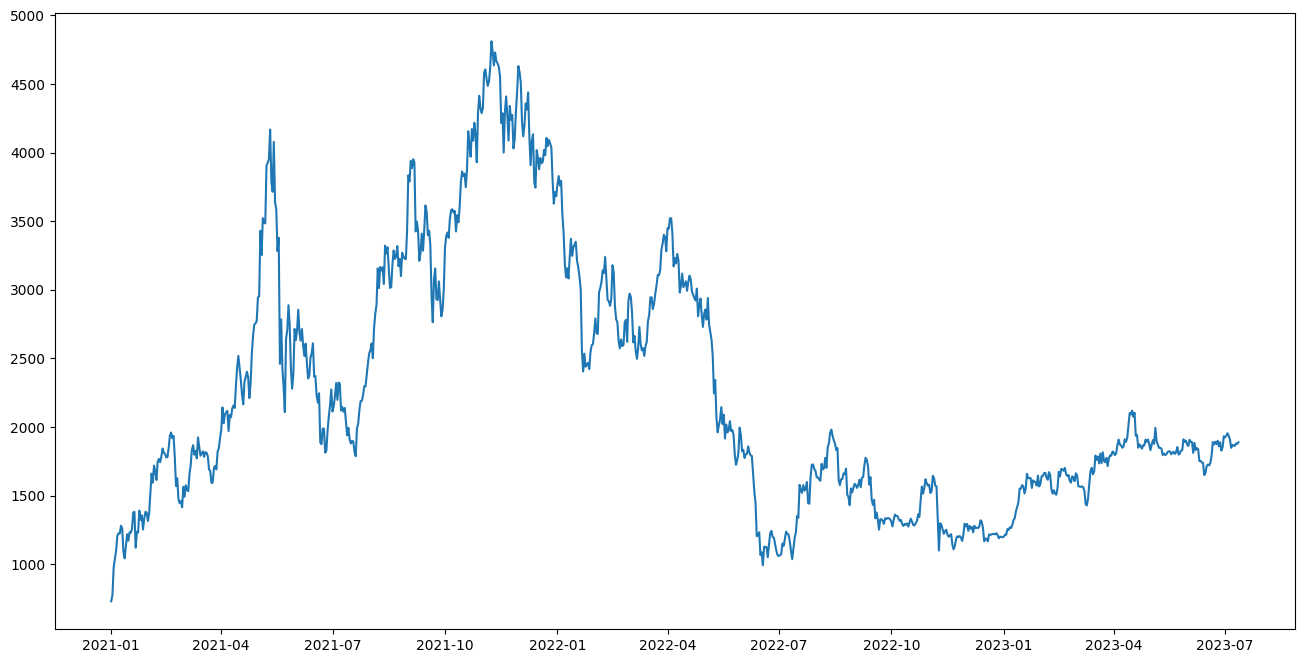

In [55]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [56]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [57]:
training_ratio=0.8
training_size=int(len(new_dataset)*training_ratio)

In [58]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values
train_data=final_dataset[0:training_size,:]
valid_data=final_dataset[training_size:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]
prediction_days = 60

for i in range(prediction_days,len(train_data)):
    x_train_data.append(scaled_data[i-prediction_days:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [59]:
x_train_data

array([[[0.        ],
        [0.01082079],
        [0.06005805],
        ...,
        [0.17874955],
        [0.16798835],
        [0.20440895]],

       [[0.01082079],
        [0.06005805],
        [0.07591542],
        ...,
        [0.16798835],
        [0.20440895],
        [0.18674511]],

       [[0.06005805],
        [0.07591542],
        [0.09055951],
        ...,
        [0.20440895],
        [0.18674511],
        [0.20713955]],

       ...,

       [[0.20536043],
        [0.14760151],
        [0.09059961],
        ...,
        [0.11867822],
        [0.12890622],
        [0.12741468]],

       [[0.14760151],
        [0.09059961],
        [0.1394258 ],
        ...,
        [0.12890622],
        [0.12741468],
        [0.13205499]],

       [[0.09059961],
        [0.1394258 ],
        [0.1364262 ],
        ...,
        [0.12741468],
        [0.13205499],
        [0.1308034 ]]])

In [60]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-prediction_days:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

678/678 - 10s - loss: 0.0064 - 10s/epoch - 14ms/step


In [61]:
X_test=[]
for i in range(prediction_days,inputs_data.shape[0]):
    X_test.append(inputs_data[i-prediction_days:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

6/6 [==============================] - 1s 7ms/step


In [62]:
lstm_model.save("./model/{}.h5".format(coin))

C:\Users\Graynote1\PycharmProjects\stock_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\Graynote1\AppData\Local\Temp\ipykernel_5252\1166615615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


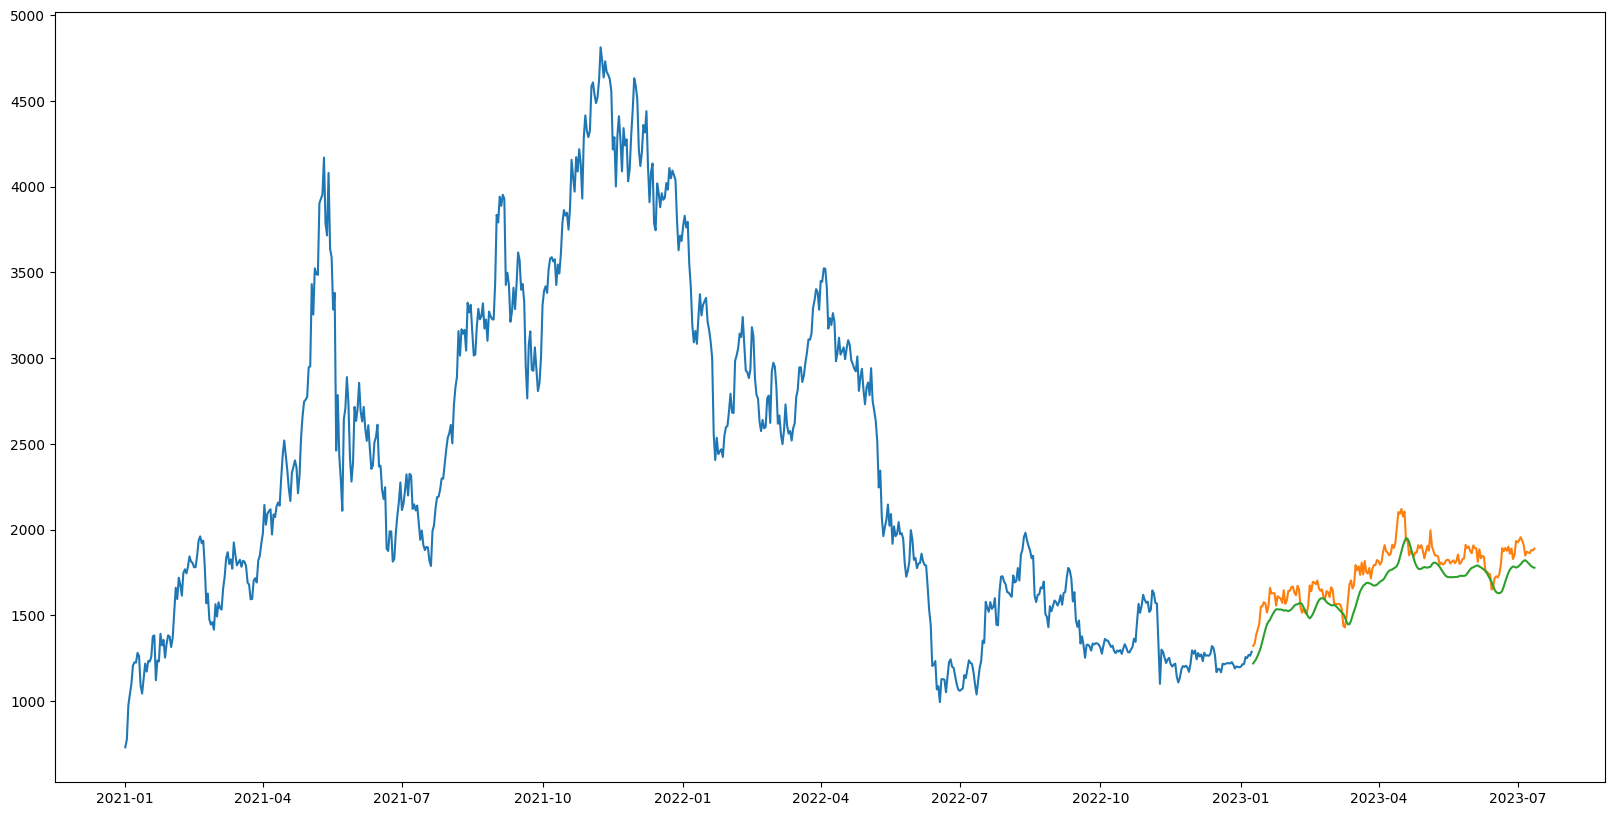

In [63]:
train_data=new_dataset[:training_size]
valid_data=new_dataset[training_size:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])